In [1]:
import psycopg2 as pg
import pandas as pd
from queries.db_queries import *
from functions.running_avg import *
from functions.helper_functions import *
from configs.definitions import *
import numpy as np
from numpy.linalg import lstsq
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
#import libraries.libraries

## Get Game Logs and Rename Abbr.

In [3]:
team_data = sql_query(curr_teams_query)

In [4]:
log_path_2023 = 'C:/Users/conor/Downloads/gl2023/gl2023.txt'
log_path_2022 = 'C:/Users/conor/Downloads/gl2022/gl2022.txt'

gamelogs_full = pd.read_csv(log_path_2023, header=None)
gamelogs = pd.concat([gamelogs_full.iloc[:,:13], gamelogs_full.iloc[:,16:19],gamelogs_full.iloc[:,102], gamelogs_full.iloc[:,104]], axis = 1)
gamelogs = gamelogs.set_axis(game_log_column_headers, axis = 1)

#Fix Abbreviations
gamelogs['Visiting Team'] = gamelogs['Visiting Team'].replace(renamed_team)
gamelogs['Home Team'] = gamelogs['Home Team'].replace(renamed_team)

running_avg_df = get_running_avg_df(gamelogs_=gamelogs, timeframe=6)

Score Game Difficulty for Each Pitcher

In [5]:
Difficulty_Score_Home = []
Difficulty_Score_Away = []
for idx, game in gamelogs.iterrows():
    date = game['Date']
    home_chllg_run = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Visiting Team'] == game['Visiting Team'])]['VTRA_S'].values
    home_chllg_overall = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Visiting Team'] == game['Visiting Team'])]['VTA_S'].values
    Difficulty_Score_Home.append(np.average([home_chllg_run,home_chllg_overall], weights= [2,1], axis=0)[0] if len(home_chllg_overall) > 0 else None)

    vis_chllg_run = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Home Team'] == game['Home Team'])]['HTRA_S'].values
    vis_chllg_overall = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Home Team'] == game['Home Team'])]['HTA_S'].values
    Difficulty_Score_Away.append(np.average([vis_chllg_run,vis_chllg_overall], weights= [2,1], axis=0)[0] if len(vis_chllg_overall) > 0 else None)

In [6]:
gamelogs['Home Challenge'] = Difficulty_Score_Home
gamelogs['Visiting Challenge'] = Difficulty_Score_Away

In [6]:
phils = gamelogs[(gamelogs['Visiting Team'] == 'PHI') | (gamelogs['Home Team'] == 'PHI')]
phils = phils.reset_index(drop=True)

phils['Outcome'] = np.where(
    (phils['Home Team'] == 'PHI') & (phils['Home Team Score'] > phils['Visiting Team Score']) | 
    (phils['Visiting Team'] == 'PHI') & (phils['Visiting Team Score'] > phils['Home Team Score']),
    'win', 
    'loss'
)
phils['Opponent'] = np.where( (phils['Home Team'] == 'PHI'), phils['Visiting Team'],phils['Home Team'])
colors = np.where(phils['Outcome'] == 'win', 'green', 'red').tolist()[6:]

phils['Challenge Score'] = np.where(phils['Home Team'] == 'PHI', phils['Home Challenge'], phils['Visiting Challenge'])

C:\Users\conor\AppData\Local\Temp\ipykernel_30068\334038990.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(phils['Challenge Score'][phils.index >= 6].index, phils['Challenge Score'][phils.index >= 6], c=colors, marker='o', edgecolor='black', s=40, cmap='coolwarm')


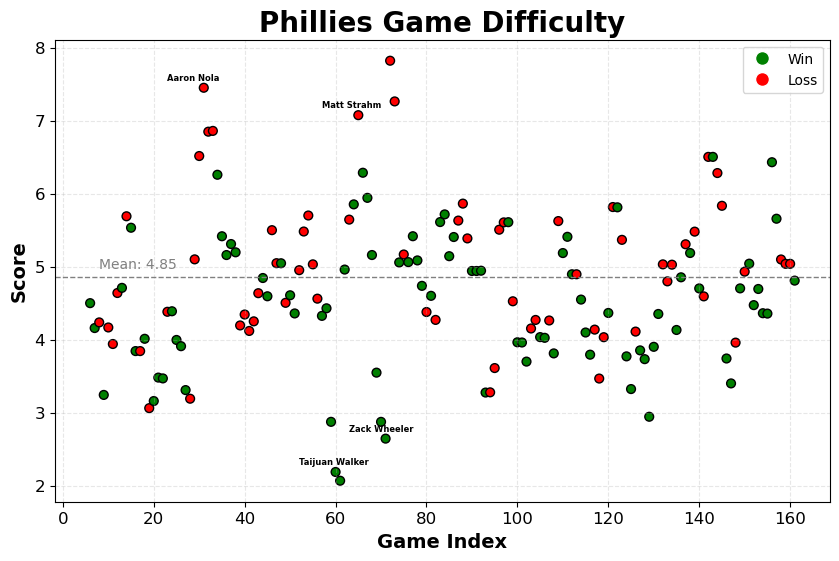

In [7]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(phils['Challenge Score'][phils.index >= 6].index, phils['Challenge Score'][phils.index >= 6], c=colors, marker='o', edgecolor='black', s=40, cmap='coolwarm')
plt.title('Phillies Game Difficulty', fontsize=20, fontweight='bold')
plt.xlabel('Game Index', fontsize=14,fontweight='bold')
plt.ylabel('Score', fontsize=14,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a color legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Win', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Loss', markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

# Adding grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.3)

# Adding mean line for reference
mean = phils['Challenge Score'].mean()
plt.axhline(mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(25, mean + 0.12, f'Mean: {mean:.2f}', color='gray', ha='right')

temp_df = avoid_overlap(phils[((phils['Challenge Score'] > 6.75)|(phils['Challenge Score'] < 2.75) ) & (phils.index >= 6)])
for i, row in temp_df.iterrows():
    if row['Home Team'] == 'PHI':
        plt.text(
            x=i - 8,
            y=row['Challenge Score'] + 0.1,
            s=row['Home SP'],
            ha='left',
            weight='bold',
            fontsize=6
        )
    elif row["Visiting Team"] == 'PHI':
          plt.text(
            x=i - 8,
            y=row['Challenge Score'] + 0.1,
            s=row['Visiting SP'],
            ha='left',
            weight='bold',
            fontsize=6
        ) 

In [ ]:
q1 = phils['Challenge Score'].quantile(0.25)
q3 = phils['Challenge Score'].quantile(0.75)
iqr = q3 - q1
tough_games = phils[(phils['Challenge Score'] >= q3 + 1.5*iqr) & (phils.index >= 6)]
easy_games = phils[(phils['Challenge Score'] <= q1 - 1.5*iqr) & (phils.index >= 6)]

In [ ]:
score_std = np.std(phils['Challenge Score'][(phils.index >= 6)])
tough_games = phils[(phils['Challenge Score'] >= mean + 2*score_std) & (phils.index >= 6)]
easy_games = phils[(phils['Challenge Score'] <= mean - 2*score_std) & (phils.index >= 6)]
outlier_games = pd.concat([easy_games, tough_games])

In [ ]:
plt.hist(outlier_games['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'loss')], edgecolor='black', alpha = 0.65, color='red')
plt.hist(outlier_games['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'win')], edgecolor='black', alpha = 0.8, color='green')

In [ ]:
plt.hist(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'loss')], edgecolor='black', alpha = 0.65, color='red', label='losses')
plt.hist(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'win')], edgecolor='black', alpha = 0.8, color='green', label = 'wins')
plt.xlabel('Score', fontsize=12,fontweight='bold')
plt.ylabel('Frequency', fontsize=12,fontweight='bold')
#plt.title('Score Histogram', fontsize=16,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='center right')
loss_mean = np.mean(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'loss')])
win_mean = np.mean(phils['Challenge Score'][(phils.index >= 6) & (phils['Outcome']== 'win')])

# Add mean line
plt.axvline(loss_mean, color='red', linestyle='dashed', linewidth=1)
plt.text(loss_mean + 0.2, plt.ylim()[1]*0.94, f'Mean Loss Score: {loss_mean:.2f}', color='red')
plt.axvline(win_mean, color='green', linestyle='dashed', linewidth=1)
plt.text(win_mean - 2.2, plt.ylim()[1]*0.94, f'Mean Win Score: {win_mean:.2f}', color='green')
plt.title('2023 Phillies Season', fontweight='bold', fontsize=14)

Determine A, b and weights for Weighted Least Squares Regression

In [7]:
gamelogs.reset_index(drop=True, inplace=True)

num_feats = 3
num_teams = len(pd.unique(gamelogs[['Home Team', 'Visiting Team']].values.ravel()))
A = np.zeros((162*30,num_teams*num_feats))
b = np.zeros((162*30,1))

team_data = team_data.sort_values(by ='Team')
team_data.reset_index(drop=True, inplace=True)

In [8]:
idx = 0
weights = []
# Group by 'Home Team' and 'Visiting Team' to calculate the occurrence of each matchup
matchup_counts = gamelogs.groupby(['Home Team', 'Visiting Team']).size().reset_index(name='Count')

# Iterate over the grouped matchups
for (home_team, visiting_team), group in gamelogs.groupby(['Home Team', 'Visiting Team']):
    home_team_idx = team_data.index[team_data['Team'] == home_team]
    visiting_team_idx = team_data.index[team_data['Team'] == visiting_team]
    
    for _, row in group.iterrows():
        # Set offensive team factor
        A[idx, home_team_idx * num_feats] = 1
        A[idx + 1, visiting_team_idx * num_feats] = 1

        # Set defensive team factor
        A[idx, visiting_team_idx * num_feats + 1] = 1
        A[idx + 1, home_team_idx * num_feats + 1] = 1

        # Set park factor (assuming a specific column index for park factors)
        A[idx, home_team_idx * num_feats + 2] = 1  # Adjust this index if park factors are in a different column
        A[idx + 1, home_team_idx * num_feats + 2] = 1

        b[idx] = row['Home Team Score']
        b[idx + 1] = row['Visiting Team Score']
        
        idx += 2
        
        weights.append(len(group))
        weights.append(len(group))

weights = np.array(weights)

Determine Weighted PF

In [9]:
# Add a constant term to the predictors
X = sm.add_constant(A)

# Fit the WLS model
wls_model = sm.WLS(b, X, weights=weights).fit()
beta = wls_model.params 
# Print the summary of the model
#print(wls_model.summary())

In [10]:
# Extract every third coefficient starting from the first coefficient
coefficients = beta[1:]
constant = coefficients[0]

park_factors = []

# Populate the park factor scores
for team in team_data['Team']:
    park_factor = coefficients[team_data.index[team_data['Team'] == team][0] * num_feats + 2]
    park_factors.append(park_factor)

# Create a new DataFrame with teams and their corresponding park factor scores
df_park_factors = pd.DataFrame({
    'Team': team_data['Team'],
    'ParkFactor': park_factors
}).sort_values(by='ParkFactor', ascending= False)

df_park_factors.reset_index(inplace=True, drop=True)
df_park_factors['NormPF'] = min_max_norm(df_park_factors,'ParkFactor')
print('Weighted Park Factors')
print(round(df_park_factors.sort_values(by='ParkFactor', ascending= False).head(),3))


Weighted Park Factors
  Team  ParkFactor  NormPF
0  COL       1.345   1.000
1  TEX       0.724   0.730
2  BOS       0.649   0.697
3  STL       0.510   0.636
4  CHC       0.474   0.621


Read in Baseball Savant's Park Factor Data

In [11]:
SavantPF = pd.read_csv('C:/Users/conor/Downloads/BaseballSavantPF2023.csv')
SavantPF['NormPF_Savant'] = min_max_norm(SavantPF,'Park Factor')

In [12]:
JoinPFs = pd.merge(df_park_factors, SavantPF, on='Team')
JoinPFs = JoinPFs.drop(columns=['Rank'])
JoinPFs['Diff'] = (abs(JoinPFs['NormPF'] - JoinPFs['NormPF_Savant'])*100).round(3)

In [ ]:
JoinPFs.sort_values(by='ParkFactor', ascending=False)

Lets Adjust ERA for Difficulty and PF Score

In [13]:
SPs = sql_query(SP_query)

In [ ]:
phils_pitchers = sql_query(Phils_SP_query)

In [14]:
Names = []
avg_diffs = []
avg_norm_pf = []

for pitcher in SPs['Full Name']:
    pf = []
    games_started = gamelogs[(gamelogs['Home SP'] == pitcher) | (gamelogs['Visiting SP'] == pitcher)]
    for idx, game in games_started.iterrows():
        if games_started.loc[idx,'Home SP'] == pitcher:
            games_started.loc[idx,'Challenge Score'] = games_started.loc[idx,'Home Challenge']
        elif games_started.loc[idx,'Visiting SP'] == pitcher:
            games_started.loc[idx,'Challenge Score'] = games_started.loc[idx,'Visiting Challenge']
        park_factor = df_park_factors['NormPF'][df_park_factors['Team'] == game['Home Team']].values
        if len(park_factor) > 0:
            pf.append(park_factor)
    avg_diff = np.mean(games_started['Challenge Score'])
    avg_norm_pf.append(round(np.mean(pf),2))
    Names.append(pitcher)
    avg_diffs.append(round(avg_diff,2))

Pitchers_2023 = pd.DataFrame({
'Name': Names,
'Avg Game Difficulty Score': avg_diffs,
'2022ERA': SPs['ERA 2022'],
'PF_Norm': avg_norm_pf
}).sort_values(by='Avg Game Difficulty Score', ascending= False)
    

C:\Users\conor\AppData\Local\Temp\ipykernel_25088\1764328486.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_started.loc[idx,'Challenge Score'] = games_started.loc[idx,'Visiting Challenge']
C:\Users\conor\AppData\Local\Temp\ipykernel_25088\1764328486.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_started.loc[idx,'Challenge Score'] = games_started.loc[idx,'Home Challenge']
C:\Users\conor\AppData\Local\Temp\ipykernel_25088\1764328486.py:12: SettingWithCopyWarning: 
A value is trying to 

In [15]:
Pitchers_2023.head(25)

,Name,Avg Game Difficulty Score,ERA,PF_Norm
60,James Kaprielian,5.20,6.340000,0.19
32,Bailey Falter,5.13,5.355000,0.45
34,Chris Flexen,5.09,6.990000,0.64
97,Luis Severino,5.08,6.650000,0.43
96,JP Sears,5.08,4.540000,0.29
57,Dakota Hudson,5.08,4.980000,0.49
115,Adam Wainwright,5.05,7.400000,0.55
78,Miles Mikolas,5.04,4.780000,0.56
82,Aaron Nola,5.03,4.460000,0.44
91,Carlos Rodon,5.03,6.850000,0.51


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(Pitchers_2023['PF_Norm'],Pitchers_2023['ERA'])
plt.title('ERA vs PF', fontsize=20, fontweight='bold')
plt.xlabel('Normal Park Factor', fontsize=14,fontweight='bold')
plt.ylabel('ERA', fontsize=14,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [ ]:
sns.pairplot(Pitchers_2023[['ERA','PF_Norm','Avg Game Difficulty Score']])

In [53]:
Pitchers_2023.reset_index(drop=True, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(Pitchers_2023[['PF_Norm','Avg Game Difficulty Score']], Pitchers_2023['2022ERA'], test_size=0.2, random_state=42)
X_train = X_train.to_numpy()
X_test =X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [54]:
inputs = tf.keras.Input(shape=(2,))
dense = tf.keras.layers.Dense(64, activation="relu")
x = dense(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="ERA_P")
# model = Sequential([
#     tf.keras.layers.Dense(52, activation='relu')(inputs), 
#     tf.keras.layers.Dense(52, activation='relu'), 
#     tf.keras.layers.Dense(1, activation='linear'),  
# ])

In [55]:
model.compile(optimizer='adam',
               loss='mse',
               metrics= ['mae','mse'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [56]:
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose=2) #, callbacks=[early_stopping])

Epoch 1/200
3/3 - 2s - 598ms/step - loss: 10.6047 - mae: 3.0915 - mse: 10.6047 - val_loss: 9.0738 - val_mae: 2.9214 - val_mse: 9.0738
Epoch 2/200
3/3 - 0s - 27ms/step - loss: 8.5546 - mae: 2.7314 - mse: 8.5546 - val_loss: 7.1610 - val_mae: 2.5722 - val_mse: 7.1610
Epoch 3/200
3/3 - 0s - 30ms/step - loss: 6.7090 - mae: 2.3815 - mse: 6.7090 - val_loss: 5.5885 - val_mae: 2.2446 - val_mse: 5.5885
Epoch 4/200
3/3 - 0s - 31ms/step - loss: 5.2874 - mae: 2.0570 - mse: 5.2874 - val_loss: 4.3400 - val_mae: 1.9452 - val_mse: 4.3400
Epoch 5/200
3/3 - 0s - 28ms/step - loss: 4.1242 - mae: 1.7599 - mse: 4.1242 - val_loss: 3.2822 - val_mae: 1.6530 - val_mse: 3.2822
Epoch 6/200
3/3 - 0s - 31ms/step - loss: 3.1932 - mae: 1.4740 - mse: 3.1932 - val_loss: 2.3676 - val_mae: 1.3776 - val_mse: 2.3676
Epoch 7/200
3/3 - 0s - 37ms/step - loss: 2.3484 - mae: 1.2019 - mse: 2.3484 - val_loss: 1.6279 - val_mae: 1.1107 - val_mse: 1.6279
Epoch 8/200
3/3 - 0s - 38ms/step - loss: 1.7202 - mae: 0.9686 - mse: 1.7202 - va

In [57]:
test_scores = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - 38ms/step - loss: 0.5817 - mae: 0.6099 - mse: 0.5817


In [67]:
X_train[0].reshape(1,-1)

array([[0.43, 4.69]])

In [ ]:
rand_int = random.ranint(range(len(X_test)))
single_sample = np.array([X_test[rand_int]]).reshape(1, -1)
single_prediction = model.predict(single_sample)
print(single_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[3.772291]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[3.7611015]], dtype=float32)

In [ ]:
model.predict(X_test)